### 90 データの準備

In [1]:
# ! tar zxvf data/kftt-data-1.0.tar.gz

In [5]:
! cat progress.py

import sys
from tqdm import tqdm

def main():
    for x in tqdm(sys.stdin):
        print(x, end='')



In [6]:
! cat ginza_tokenize.py

import re
import sys
import spacy

def main():
    ginza = spacy.load('ja_ginza')
    pattern = re.compile(r'\s+')
    for x in sys.stdin:
        x = x.strip()
        x = pattern.sub(' ', x)
        x = ginza.make_doc(x)
        x = ' '.join([doc.text for doc in x])
        print(x)

if __name__ == '__main__':
    main()



In [10]:
! parallel --pipe -j 16 -k --L 30000 'python ginza_tokenize.py' \
    < kftt-data-1.0/data/orig/kyoto-train.ja \
    2> /dev/null \
    | python progress.py \
    > ch10/train.spacy.ja

440288it [01:20, 5500.47it/s] 


In [11]:
! python ginza_tokenize.py < kftt-data-1.0/data/orig/kyoto-dev.ja > ch10/dev.spacy.ja

In [12]:
! python ginza_tokenize.py < kftt-data-1.0/data/orig/kyoto-test.ja > ch10/test.spacy.ja

In [13]:
! head ch10/train.spacy.ja

雪舟 （ せっ しゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。
日本 の 水墨画 を 一変 さ せ た 。
諱 は 「 等楊 （ とう よう ） 」 、 もしくは 「 拙 宗 （ せっ しゅう ） 」 と 号し た 。
備中 国 に 生まれ 、 京都 ・ 相国 寺 に 入っ て から 周防 国 に 移る 。
その 後 遣明 使 に 随行 し て 中国 （ 明 ） に 渡っ て 中国 の 水墨画 を 学ん だ 。
作品 は 数多く 、 中国 風 の 山水画 だけ で なく 人物画 や 花鳥画 も よく し た 。
大胆 な 構図 と 力強い 筆線 は 非常 に 個性的 な 画風 を 作り出し て いる 。
現存 する 作品 の うち 6 点 が 国宝 に 指定 さ れ て おり 、 日本 の 画家 の なか で も 別格 の 評価 を 受け て いる と いえる 。
この ため 、 花鳥 図 屏風 など に 「 伝 雪舟 筆 」 さ れる 作品 は 大変 多い 。
真筆 で ある か 専門家 の 間 で も 意見 の 分かれる もの も 多々 ある 。


In [14]:
! cat spacy_tokenize.py

import re
import sys
import spacy

def main():
    nlp = spacy.load('en')
    pattern = re.compile(r'\s+')
    for x in sys.stdin:
        x = x.strip()
        x = pattern.sub(' ', x)
        x = nlp.make_doc(x)
        x = ' '.join([doc.text for doc in x])
        print(x)

if __name__ == '__main__':
    main()



In [15]:
! python spacy_tokenize.py < kftt-data-1.0/data/orig/kyoto-train.en | python progress.py > ch10/train.spacy.en

440288it [01:13, 6020.57it/s]


In [16]:
! python spacy_tokenize.py < kftt-data-1.0/data/orig/kyoto-dev.en > ch10/dev.spacy.en

In [17]:
! python spacy_tokenize.py < kftt-data-1.0/data/orig/kyoto-test.en > ch10/test.spacy.en

In [18]:
! head ch10/train.spacy.en

Known as Sesshu ( 1420 - 1506 ) , he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century , and was called a master painter .
He revolutionized the Japanese ink painting .
He was given the posthumous name " Toyo " or " Sesshu ( 拙宗 ) . "
Born in Bicchu Province , he moved to Suo Province after entering SShokoku - ji Temple in Kyoto .
Later he accompanied a mission to Ming Dynasty China and learned Chinese ink painting .
His works were many , including not only Chinese - style landscape paintings , but also portraits and pictures of flowers and birds .
His bold compositions and strong brush strokes constituted an extremely distinctive style .
6 of his extant works are designated national treasures . Indeed , he is considered to be extraordinary among Japanese painters .
For this reason , there are a great many artworks that are attributed to him , such as folding screens with pictures of flowers and that birds are painted on them .
There a

### 91. 機械翻訳モデルの訓練

In [19]:
# ! pip install fairseq==0.10.2

In [22]:
!fairseq-preprocess -s ja -t en \
    --trainpref ch10/train.spacy \
    --validpref ch10/dev.spacy \
    --destdir ch10/data91  \
    --thresholdsrc 5 \
    --thresholdtgt 5 \
    --workers 20

2021-04-05 22:57:08 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='ch10/data91', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang='ja', srcdict=None, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=5, thresholdtgt=5, tokenizer=None, tpu=False, trainpref='ch10/tra

In [24]:
! fairseq-train ch10/data91 \
    --fp16 \
    --save-dir ch10/save91 \
    --max-epoch 10 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-decoder-input-output-embed \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.001 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/91.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(


### 92. 機械翻訳モデルの適用

In [25]:
! fairseq-interactive ch10/data91 \
    --path ch10/save91/checkpoint10.pt \
    --buffer-size 128 \
    --batch-size 128 \
    --beam 4 \
    --lenpen 0.6 \
    < ch10/dev.spacy.ja \
    | grep '^H' \
    | cut -f3 \
    > ch10/92.out

### 93. BLEUスコアの計測

In [26]:
! sacremoses -l en detokenize < ch10/92.out | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en

BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.5.1 = 17.7 47.5/22.7/12.5/7.4 (BP = 1.000 ratio = 1.122 hyp_len = 27236 ref_len = 24281)


### 94. ビーム探索

In [27]:
%%bash
for N in {1..10} ; do
    fairseq-interactive ch10/data91 \
        --path ch10/save91/checkpoint10.pt \
        --buffer-size 128 \
        --batch-size 64 \
        --beam $N \
        --lenpen 0.6 \
        < ch10/dev.spacy.ja \
        | grep '^H' \
        | cut -f3 \
        > ch10/94.${N}.out
done

In [31]:
%%bash
for N in {1..10} ; do
    sacremoses -l en detokenize < ch10/94.${N}.out | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en > ch10/94.${N}.score
done

In [32]:
import matplotlib.pyplot as plt

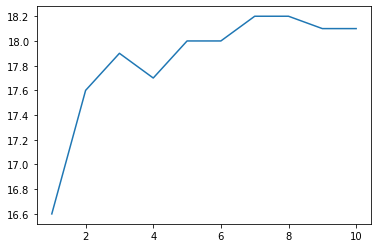

In [33]:
def read_score(filename):
    with open(filename) as f:
        x = f.readline()
        x = re.search(r'(?<= )\d*\.\d*(?= )', x)
        return float(x.group())

xs = range(1, 11)
ys = [read_score(f'ch10/94.{x}.score') for x in xs]
plt.plot(xs, ys)
plt.show()

### 95. サブワード化

In [34]:
# ! pip install sentencepiece

In [35]:
! cat ch10/train.spacy.ja ch10/train.spacy.en > ch10/train.spacy.jaen

In [37]:
import sentencepiece as spm

In [38]:
spm.SentencePieceTrainer.Train(
    input = 'ch10/train.spacy.jaen',
    model_prefix = 'ch10/kyoto',
    model_type = 'bpe',
    vocab_size = 16000,
    character_coverage = 1.0,
    num_threads = 16)

In [39]:
sp = spm.SentencePieceProcessor()
sp.Load('ch10/kyoto.model')

True

In [40]:
def sp_encode(src, dst, alpha=None):
    with open(src) as f, open(dst, 'w') as g:
        for x in f:
            x = x.strip()
            x = re.sub(r'\s+', ' ', x)
            if alpha is None:
                x = sp.encode(x, out_type=str)
            else:
                x = sp.encode(x, out_type=str, enable_sampling=True, alpha=alpha)
            x = ' '.join(x)
            print(x, file=g)

In [41]:
dev_ja_src = 'ch10/dev.spacy.ja'
dev_en_src = 'ch10/dev.spacy.en'
test_ja_src = 'ch10/test.spacy.ja'
test_en_src = 'ch10/test.spacy.en'
dev_ja_dst = 'ch10/dev.sub.ja'
dev_en_dst = 'ch10/dev.sub.en'
test_ja_dst = 'ch10/test.sub.ja'
test_en_dst = 'ch10/test.sub.en'

sp_encode(dev_ja_src, dev_ja_dst)
sp_encode(dev_en_src, dev_en_dst)
sp_encode(test_ja_src, test_ja_dst)
sp_encode(test_en_src, test_en_dst)

for epoch in range(1, 11):
    src = 'ch10/train.spacy.ja'
    dst = 'ch10/train.sub.{}.ja'.format(epoch)
    sp_encode(src, dst, alpha=0.1)

for epoch in range(1, 11):
    src = 'ch10/train.spacy.en'
    dst = 'ch10/train.sub.{}.en'.format(epoch)
    sp_encode(src, dst, alpha=0.1)

In [46]:
! head ch10/train.sub.1.ja

▁雪 舟 ▁( ▁せ っ ▁し ゅう ▁、 ▁14 20 ▁年 ▁( ▁応永 ▁27 ▁年 ▁) ▁- ▁150 6 ▁年 ▁( ▁永正 ▁3 ▁年 ▁ ) ▁) ▁は ▁号 ▁ で ▁、 ▁15 ▁世紀 ▁後半 ▁室町 ▁時代 ▁に ▁活躍 ▁し ▁た ▁水 墨 ▁画 家 ▁・ ▁禅 僧 ▁で ▁ 、 ▁画 聖 ▁と ▁も ▁称 え ▁られる ▁。
▁日本 ▁の ▁水 墨 画 ▁を ▁一 変 ▁さ ▁せ ▁ た ▁。
▁諱 ▁は ▁「 ▁等 楊 ▁( ▁とう ▁よう ▁) ▁」 ▁、 ▁もしくは ▁「 ▁ 拙 ▁宗 ▁( ▁せ っ ▁し ゅう ▁) ▁」 ▁と ▁号 し ▁た ▁。
▁備 中 ▁ 国 ▁に ▁生まれ ▁、 ▁京都 ▁・ ▁相 国 ▁寺 ▁に ▁入っ ▁て ▁から ▁周 防 ▁国 ▁に ▁移 る ▁。
▁その ▁後 ▁遣 明 ▁使 ▁ に ▁随 行 ▁し ▁て ▁中国 ▁( ▁明 ▁) ▁ に ▁渡 っ ▁ て ▁中 国 ▁の ▁水 墨 画 ▁を ▁学ん ▁だ ▁。
▁作 品 ▁は ▁数多く ▁、 ▁中国 ▁風 ▁の ▁山 水 画 ▁だけ ▁ で ▁な く ▁人物 画 ▁や ▁花 鳥 画 ▁も ▁よく ▁し ▁た ▁。
▁大 胆 ▁な ▁構 図 ▁と ▁力 強 い ▁ 筆 線 ▁は ▁非常 ▁に ▁個 性 的 ▁な ▁画 風 ▁を ▁作り 出し ▁て ▁いる ▁。
▁現存 ▁する ▁作品 ▁の ▁うち ▁6 ▁点 ▁が ▁国宝 ▁に ▁指 定 ▁さ ▁れ ▁て ▁おり ▁、 ▁日本 ▁の ▁画 家 ▁の ▁なか ▁で ▁も ▁別 格 ▁の ▁ 評 価 ▁を ▁受け ▁て ▁いる ▁と ▁いえる ▁。
▁この ▁た め ▁、 ▁花 鳥 ▁図 ▁屏 風 ▁など ▁に ▁「 ▁伝 ▁雪 舟 ▁ 筆 ▁」 ▁さ ▁れる ▁作 品 ▁は ▁大 変 ▁ 多 い ▁。
▁真 筆 ▁で ▁ある ▁か ▁専 門 家 ▁の ▁間 ▁で ▁も ▁ 意 見 ▁ の ▁分か れる ▁もの ▁も ▁多 々 ▁ある ▁。


In [47]:
! head ch10/train.sub.2.ja

▁ 雪 舟 ▁( ▁せ っ ▁し ゅう ▁、 ▁1 4 20 ▁年 ▁( ▁応永 ▁27 ▁年 ▁) ▁- ▁150 6 ▁年 ▁( ▁永正 ▁3 ▁年 ▁) ▁) ▁は ▁号 ▁で ▁、 ▁15 ▁世紀 ▁後半 ▁室町 ▁時代 ▁に ▁活躍 ▁し ▁た ▁水 墨 ▁画 家 ▁・ ▁禅 僧 ▁で ▁ 、 ▁画 聖 ▁と ▁ も ▁称 え ▁られる ▁。
▁日本 ▁の ▁水 墨 画 ▁を ▁一 変 ▁さ ▁せ ▁た ▁。
▁諱 ▁は ▁「 ▁等 楊 ▁ ( ▁とう ▁よう ▁) ▁」 ▁、 ▁も しく は ▁ 「 ▁ 拙 ▁宗 ▁( ▁せ っ ▁ し ゅう ▁ ) ▁」 ▁と ▁号 し ▁た ▁ 。
▁備 中 ▁国 ▁ に ▁生 ま れ ▁、 ▁京都 ▁・ ▁ 相 国 ▁ 寺 ▁に ▁入っ ▁て ▁から ▁周 防 ▁国 ▁に ▁移 る ▁。
▁その ▁後 ▁ 遣 明 ▁使 ▁に ▁随 行 ▁し ▁て ▁中国 ▁ ( ▁明 ▁) ▁に ▁渡 っ ▁て ▁中国 ▁の ▁水 墨 画 ▁を ▁学ん ▁だ ▁。
▁作品 ▁は ▁数多く ▁ 、 ▁中国 ▁風 ▁の ▁山 水 画 ▁だけ ▁で ▁なく ▁人物 画 ▁や ▁花 鳥 画 ▁も ▁よく ▁し ▁た ▁。
▁大 胆 ▁な ▁構 図 ▁と ▁ 力 強 い ▁筆 線 ▁は ▁非常 ▁に ▁個 性 的 ▁な ▁画 風 ▁を ▁作り 出 し ▁て ▁いる ▁。
▁現存 ▁する ▁作品 ▁の ▁うち ▁6 ▁ 点 ▁が ▁国宝 ▁に ▁指定 ▁さ ▁れ ▁て ▁おり ▁、 ▁日本 ▁の ▁画 家 ▁の ▁な か ▁ で ▁も ▁別 格 ▁の ▁評価 ▁を ▁受け ▁て ▁いる ▁ と ▁いえる ▁。
▁この ▁ため ▁、 ▁花 鳥 ▁図 ▁屏 風 ▁ な ど ▁に ▁「 ▁伝 ▁ 雪 舟 ▁筆 ▁」 ▁さ ▁れる ▁作品 ▁は ▁大 変 ▁多い ▁。
▁真 筆 ▁で ▁ある ▁か ▁専門 家 ▁の ▁間 ▁で ▁も ▁意見 ▁の ▁分か れる ▁もの ▁も ▁多 々 ▁ある ▁ 。


In [48]:
! head ch10/train.sub.1.en

▁K n ow n ▁as ▁Sess hu ▁( ▁1 4 20 ▁- ▁15 0 6 ▁) ▁, ▁he ▁was ▁a n ▁ink ▁p a in ter ▁and ▁Z en ▁monk ▁active ▁in ▁the ▁M u rom achi ▁period ▁in ▁the ▁latter ▁half ▁of ▁the ▁15 th ▁ce n t ury ▁, ▁an d ▁was ▁called ▁ a ▁master ▁painter ▁.
▁He ▁revol ution ized ▁the ▁J a p an ese ▁ink ▁p ain t ing ▁.
▁He ▁was ▁given ▁the ▁posthumous ▁name ▁" ▁Toyo ▁" ▁o r ▁" ▁Sess hu ▁( ▁ 拙 宗 ▁ ) ▁. ▁"
▁B orn ▁in ▁B ic chu ▁Prov ince ▁, ▁he ▁moved ▁to ▁Su o ▁Province ▁a f ter ▁entering ▁S S ho koku ▁ - ▁ ji ▁Temple ▁in ▁Kyoto ▁.
▁ L ater ▁he ▁accompan i ed ▁a ▁mission ▁to ▁Ming ▁Dynasty ▁China ▁and ▁learned ▁Chinese ▁ink ▁p a in ting ▁.
▁His ▁works ▁were ▁man y ▁, ▁including ▁not ▁only ▁Chinese ▁ - ▁style ▁l an ds cape ▁paintings ▁, ▁but ▁also ▁portra its ▁an d ▁pictures ▁of ▁f low ers ▁and ▁bir ds ▁.
▁ H is ▁b old ▁comp osition s ▁and ▁strong ▁br ush ▁st ro k es ▁con stit uted ▁a n ▁ e xt reme ly ▁dist inc t ive ▁style ▁ .
▁6 ▁of ▁his ▁ext ant ▁works ▁are ▁designated ▁nat i o n al ▁treasures ▁. ▁In de ed ▁

In [49]:
! head ch10/train.sub.2.en

▁K nown ▁as ▁Sess hu ▁( ▁14 20 ▁- ▁150 6 ▁) ▁, ▁he ▁ w as ▁ an ▁ink ▁painter ▁and ▁Zen ▁mon k ▁active ▁in ▁the ▁Muromachi ▁period ▁in ▁the ▁ l atter ▁half ▁of ▁the ▁15 th ▁c en t ur y ▁ , ▁and ▁was ▁called ▁a ▁mas ter ▁painter ▁.
▁He ▁re v ol ution ized ▁the ▁Japanese ▁ink ▁p a in ting ▁.
▁He ▁was ▁g i ven ▁the ▁pos thum ous ▁name ▁" ▁To yo ▁" ▁o r ▁" ▁Sess hu ▁( ▁ 拙 宗 ▁) ▁. ▁"
▁B orn ▁in ▁B ic chu ▁Province ▁, ▁he ▁moved ▁to ▁Su o ▁Province ▁after ▁entering ▁S S ho koku ▁- ▁ji ▁Temple ▁in ▁ K y oto ▁.
▁Later ▁he ▁accompanied ▁a ▁mis s i o n ▁to ▁Ming ▁D yn ast y ▁China ▁and ▁learned ▁Chinese ▁ink ▁painting ▁.
▁H is ▁works ▁w er e ▁many ▁, ▁in c lud ing ▁not ▁only ▁Chinese ▁- ▁style ▁lands cape ▁pain tings ▁, ▁but ▁also ▁portra its ▁and ▁pictures ▁of ▁f low ers ▁and ▁bir ds ▁.
▁His ▁b old ▁comp osition s ▁and ▁strong ▁br ush ▁str ok es ▁con stit ut ed ▁an ▁extremely ▁dist inct ive ▁style ▁.
▁6 ▁of ▁his ▁ e xt an t ▁w or ks ▁are ▁designated ▁nation a l ▁ t re asures ▁. ▁I n de ed ▁, ▁he

In [52]:
%%bash
fairseq-preprocess -s ja -t en \
    --trainpref ch10/train.sub.1 \
    --validpref ch10/dev.sub \
    --destdir ch10/data95.1 \
    --joined-dictionary \
    --workers 16

2021-04-06 00:54:36 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='ch10/data95.1', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang='ja', srcdict=None, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, tpu=False, trainpref='ch10/tr

In [53]:
%%bash
for N in {2..10}; do
    fairseq-preprocess -s ja -t en \
        --trainpref ch10/train.sub.$N \
        --validpref ch10/dev.sub \
        --destdir ch10/data95.$N  \
        --srcdict ch10/data95.1/dict.ja.txt \
        --joined-dictionary \
        --workers 16
done

2021-04-06 00:55:47 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='ch10/data95.2', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang='ja', srcdict='ch10/data95.1/dict.ja.txt', target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, tpu=Fa

In [54]:
! fairseq-train \
    ch10/data95.1:ch10/data95.2:ch10/data95.3:ch10/data95.4:ch10/data95.5:ch10/data95.6:ch10/data95.7:ch10/data95.8:ch10/data95.9:ch10/data95.10 \
    --fp16 \
    --save-dir ch10/save95 \
    --max-epoch 10 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-all-embeddings \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.001 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/95.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
epoch 001: 100%|▉| 1462/1463 [03:36<00:00,  6.70it/s, loss=7.425, nll_loss=6.341
epoch 001 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  12%|█       | 1/8 [00:01<00:08,  1.22s/it]
epoch 001 | valid on 'valid' subset:  75%|██████  | 6/8 [00:01<00:00,  5.97it/s]
epoch 002: 100%|▉| 1463/1464 [03:39<00:00,  6.52it/s, loss=6.143, nll_loss=4.865
epoch 002 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:

In [55]:
%%bash
for N in {1..10}; do
    fairseq-interactive ch10/data95.1 \
        --path ch10/save95/checkpoint10.pt \
        --buffer-size 128 \
        --batch-size 64 \
        --beam $N \
        --lenpen 0.6 \
        < ch10/dev.sub.ja \
        | grep '^H' \
        | cut -f3 \
        > ch10/95.${N}.out
done

In [57]:
! head ch10/95.4.out

▁The ▁Rin zai ▁sect ▁( ▁Rin zai ▁ s ect ▁or ▁Rin zai ▁sect ▁) ▁is ▁one ▁of ▁the ▁five ▁Zen ▁sects ▁of ▁China ▁( ▁Rin zai ▁, ▁I gyo ▁, ▁S oto ▁, ▁Un mon ▁, ▁and ▁H og an ▁) ▁, ▁and ▁its ▁founder ▁was ▁G igen ▁R IN ZA I ▁( ▁? ▁- ▁86 7 ▁) ▁of ▁Tang ▁.
▁He ▁was ▁known ▁for ▁his ▁nickn ame ▁" ▁K atsu ▁no ▁Rin zai ▁" ▁and ▁" ▁Rin zai ▁Sho gun ▁, ▁" ▁and ▁he ▁reached ▁the ▁pe ak ▁of ▁the ▁prosper ity ▁of ▁Chinese ▁Zen ▁as ▁its ▁character istic ▁.
▁Kan n az en ▁is ▁a ▁kan n az en ▁( ▁med itation ▁of ▁med itation ▁) ▁, ▁which ▁is ▁intended ▁to ▁see ▁by ▁study ing ▁Ko an ▁, ▁and ▁this ▁is ▁different ▁from ▁M ok usho zen ▁of ▁the ▁S oto ▁sect ▁, ▁which ▁is ▁just ▁Z az en ▁.
▁Rin zai ▁Sect ▁in ▁China
▁As ▁the ▁name ▁suggest s ▁, ▁the ▁Rin zai ▁sect ▁started ▁by ▁G ig en ▁R IN ZA I ▁, ▁the ▁founder ▁of ▁the ▁ s ect ▁at ▁the ▁end ▁of ▁the ▁Tang ▁D y n ast y ▁.
▁Rin zai ▁was ▁a ▁dis cip le ▁of ▁Ki un ▁O BA K U ▁, ▁based ▁in ▁H u an ▁Province ▁, ▁and ▁expand ed ▁its ▁influence ▁by ▁supp or ting ▁W ang

In [58]:
def sp_decode(src, dst):
    with open(src) as f, open(dst, 'w') as g:
        for x in f:
            x = x.strip().split()
            x = ''.join(x).replace('▁', ' ')
            print(x, file=g)

for i in range(1, 11):
    src = 'ch10/95.{}.out'.format(i)
    dst = 'ch10/95.{}.decoded'.format(i)
    sp_decode(src, dst)

In [59]:
%%bash
for N in {1..10}; do
    sacremoses -l en detokenize < ch10/95.${N}.decoded | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en > ch10/95.${N}.score
done

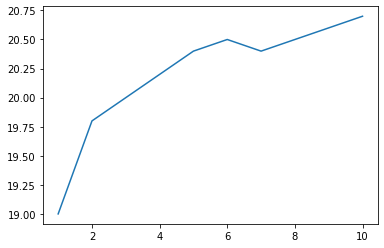

In [61]:
xs = range(1, 11)
ys = [read_score(f'ch10/95.{x}.score') for x in xs]
plt.plot(xs, ys)
plt.show()

### 96. 学習過程の可視化

In [62]:
# ! pip install tensorflow tensorboardX

In [63]:
! fairseq-train ch10/data91 \
    --fp16 \
    --tensorboard-logdir ch10/log96 \
    --save-dir ch10/save96 \
    --max-epoch 3 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-decoder-input-output-embed \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.001 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/96.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
epoch 001: 100%|▉| 874/875 [02:58<00:00,  4.92it/s, loss=8.464, nll_loss=7.363, 
epoch 001 | valid on 'valid' subset:   0%|                | 0/6 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  17%|█▎      | 1/6 [00:01<00:06,  1.33s/it]
epoch 001 | valid on 'valid' subset:  83%|██████▋ | 5/6 [00:01<00:00,  4.49it/s]
epoch 002: 100%|▉| 874/875 [03:00<00:00,  4.73it/s, loss=6.735, nll_loss=5.343, 
epoch 002 | valid on 'valid' subset:   0%|                | 0/6 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:

tensorboradを起動してlocalhost:6006(など)にアクセスすると学習過程が見れます

<img src="tensorboard.png">

### 97. ハイパー・パラメータの調整

In [64]:
! fairseq-train \
    ch10/data95.1:ch10/data95.2:ch10/data95.3:ch10/data95.4:ch10/data95.5:ch10/data95.6:ch10/data95.7:ch10/data95.8:ch10/data95.9:ch10/data95.10 \
    --fp16 \
    --save-dir ch10/save97a \
    --max-epoch 10 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-all-embeddings \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.003 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/97a.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
epoch 001: 100%|▉| 1462/1463 [03:37<00:00,  6.67it/s, loss=6.758, nll_loss=5.566
epoch 001 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  12%|█       | 1/8 [00:01<00:07,  1.08s/it]
epoch 001 | valid on 'valid' subset:  75%|██████  | 6/8 [00:01<00:00,  6.62it/s]
epoch 002: 100%|▉| 1463/1464 [03:39<00:00,  6.51it/s, loss=5.8, nll_loss=4.477, 
epoch 002 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:

In [65]:
! fairseq-train \
    ch10/data95.1:ch10/data95.2:ch10/data95.3:ch10/data95.4:ch10/data95.5:ch10/data95.6:ch10/data95.7:ch10/data95.8:ch10/data95.9:ch10/data95.10 \
    --fp16 \
    --save-dir ch10/save97b \
    --max-epoch 10 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-all-embeddings \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.005 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/97b.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
epoch 001: 100%|▉| 1462/1463 [03:39<00:00,  6.65it/s, loss=6.624, nll_loss=5.411
epoch 001 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  12%|█       | 1/8 [00:01<00:07,  1.14s/it]
epoch 001 | valid on 'valid' subset:  75%|██████  | 6/8 [00:01<00:00,  6.34it/s]
epoch 002: 100%|▉| 1463/1464 [03:39<00:00,  6.49it/s, loss=5.878, nll_loss=4.571
epoch 002 | valid on 'valid' subset:   0%|                | 0/8 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:

In [66]:
! fairseq-interactive ch10/data95.1 \
    --path ch10/save97a/checkpoint10.pt \
    --buffer-size 128 \
    --batch-size 64 \
    --beam 4 \
    --lenpen 0.6 \
    < ch10/dev.sub.ja \
    | grep '^H' \
    | cut -f3 \
    > ch10/97a.out

In [67]:
! fairseq-interactive ch10/data95.1 \
    --path ch10/save97b/checkpoint10.pt \
    --buffer-size 128 \
    --batch-size 64 \
    --beam 4 \
    --lenpen 0.6 \
    < ch10/dev.sub.ja \
    | grep '^H' \
    | cut -f3 \
    > ch10/97b.out

In [68]:
sp_decode('ch10/97a.out', 'ch10/97a.decoded')
sp_decode('ch10/97b.out', 'ch10/97b.decoded')

In [69]:
! sacremoses -l en detokenize < ch10/95.4.decoded | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en
! sacremoses -l en detokenize < ch10/97a.decoded  | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en
! sacremoses -l en detokenize < ch10/97b.decoded  | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en

BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.5.1 = 20.2 52.6/25.7/14.5/8.6 (BP = 1.000 ratio = 1.034 hyp_len = 25105 ref_len = 24281)
BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.5.1 = 20.2 52.7/25.7/14.3/8.6 (BP = 1.000 ratio = 1.024 hyp_len = 24869 ref_len = 24281)
BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.5.1 = 19.6 51.9/25.0/13.8/8.2 (BP = 1.000 ratio = 1.013 hyp_len = 24597 ref_len = 24281)


### 98. ドメイン適応

In [73]:
! cut -f 1 data/raw/raw | \
    parallel --pipe -j 16 -k --L 50000 'python spacy_tokenize.py' \
    2> /dev/null \
    | python progress.py \
    > ch10/jsec.spacy.en

2801388it [00:21, 132094.48it/s]


In [74]:
! cut -f 2 data/raw/raw | \
    parallel --pipe -j 16 -k --L 50000 'python ginza_tokenize.py' \
    2> /dev/null \
    | python progress.py \
    > ch10/jsec.spacy.ja

2801388it [03:38, 12801.68it/s] 


In [80]:
! cat ch10/jsec.spacy.en ch10/train.spacy.en ch10/train.spacy.en ch10/train.spacy.en > ch10/98.spacy.en
! cat ch10/jsec.spacy.ja ch10/train.spacy.ja ch10/train.spacy.ja ch10/train.spacy.ja > ch10/98.spacy.ja
! cat ch10/98.spacy.en ch10/98.spacy.ja > ch10/98.spacy.jaen

In [81]:
spm.SentencePieceTrainer.Train(
    input = 'ch10/98.spacy.jaen',
    model_prefix = 'ch10/98',
    model_type = 'bpe',
    vocab_size = 16000,
    character_coverage = 1.0,
    num_threads = 16)

In [82]:
sp = spm.SentencePieceProcessor()
sp.Load('ch10/98.model')

True

In [84]:
dev_ja_src = 'ch10/dev.spacy.ja'
dev_en_src = 'ch10/dev.spacy.en'
test_ja_src = 'ch10/test.spacy.ja'
test_en_src = 'ch10/test.spacy.en'
dev_ja_dst = 'ch10/dev.98.ja'
dev_en_dst = 'ch10/dev.98.en'
test_ja_dst = 'ch10/test.98.ja'
test_en_dst = 'ch10/test.98.en'

sp_encode(dev_ja_src, dev_ja_dst)
sp_encode(dev_en_src, dev_en_dst)
sp_encode(test_ja_src, test_ja_dst)
sp_encode(test_en_src, test_en_dst)

for epoch in range(1, 11):
    src = 'ch10/98.spacy.ja'
    dst = 'ch10/98.sub.{}.ja'.format(epoch)
    sp_encode(src, dst, alpha=0.1)

for epoch in range(1, 11):
    src = 'ch10/98.spacy.en'
    dst = 'ch10/98.sub.{}.en'.format(epoch)
    sp_encode(src, dst, alpha=0.1)

In [87]:
%%bash
fairseq-preprocess -s ja -t en \
    --trainpref ch10/98.sub.1 \
    --validpref ch10/dev.98 \
    --destdir ch10/data98.1 \
    --joined-dictionary \
    --workers 16

2021-04-06 21:51:10 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='ch10/data98.1', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang='ja', srcdict=None, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, tpu=False, trainpref='ch10/98

In [88]:
%%bash
for N in {2..10}; do
    fairseq-preprocess -s ja -t en \
        --trainpref ch10/98.sub.$N \
        --validpref ch10/dev.98 \
        --destdir ch10/data98.$N  \
        --srcdict ch10/data98.1/dict.ja.txt \
        --joined-dictionary \
        --workers 16
done

2021-04-06 21:57:47 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_shard_count=1, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='ch10/data98.2', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, scoring='bleu', seed=1, source_lang='ja', srcdict='ch10/data98.1/dict.ja.txt', target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, tpu=Fa

In [89]:
! fairseq-train \
    ch10/data98.1:ch10/data98.2:ch10/data98.3:ch10/data98.4:ch10/data98.5:ch10/data98.6:ch10/data98.7:ch10/data98.8:ch10/data98.9:ch10/data98.10 \
    --fp16 \
    --save-dir ch10/save98 \
    --max-epoch 10 \
    --arch transformer \
    --encoder-normalize-before --decoder-normalize-before \
    --share-all-embeddings \
    --dropout 0.1 --attention-dropout 0.1 --activation-dropout 0.1 \
    --optimizer adam --adam-betas '(0.9, 0.999)' \
    --lr 0.001 --lr-scheduler inverse_sqrt --warmup-updates 4000 --warmup-init-lr 1e-07 \
    --update-freq 2 \
    --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 4096 > ch10/98.log

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/torch/nn/parallel/distributed.py:425: UserWarning: The `check_reduction` argument in `DistributedDataParallel` module is deprecated. Please avoid using it.
  warnings.warn(
epoch 001: 100%|▉| 7190/7191 [18:04<00:00,  6.89it/s, loss=5.179, nll_loss=3.792
epoch 001 | valid on 'valid' subset:   0%|                | 0/9 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:  11%|▉       | 1/9 [00:01<00:10,  1.31s/it]
epoch 001 | valid on 'valid' subset:  67%|█████▎  | 6/9 [00:01<00:00,  5.58it/s]
epoch 002: 100%|▉| 7190/7191 [18:07<00:00,  6.66it/s, loss=4.756, nll_loss=3.323
epoch 002 | valid on 'valid' subset:   0%|                | 0/9 [00:00<?, ?it/s]
epoch 002 | valid on 'valid' subset:

In [90]:
! fairseq-interactive ch10/data98.1 \
    --path ch10/save98/checkpoint10.pt \
    --buffer-size 128 \
    --batch-size 64 \
    --beam 4 \
    --lenpen 0.6 \
    < ch10/dev.98.ja \
    | grep '^H' \
    | cut -f3 \
    > ch10/98.out

In [91]:
sp_decode('ch10/98.out',  'ch10/98.decoded')

In [93]:
! sacremoses -l en detokenize < ch10/98.decoded | sacrebleu kftt-data-1.0/data/orig/kyoto-dev.en

BLEU+case.mixed+numrefs.1+smooth.exp+tok.13a+version.1.5.1 = 21.3 53.2/26.8/15.4/9.4 (BP = 1.000 ratio = 1.047 hyp_len = 25424 ref_len = 24281)


### 99. 翻訳サーバの構築

ウェブアプリケーションの形式でやるべきなので，jupyter notebook上では無理です．